# Introduction to Recommender Systems

<p align="center">
    <img width="721" alt="cover-image" src="https://user-images.githubusercontent.com/49638680/204351915-373011d3-75ac-4e21-a6df-99cd1c552f2c.png">
</p>

---

# Bayesian Personalised Ranking

The aim of this lecture is to build a recommendation engine making use of the **Bayesian Personalised Ranking** (BPR) algorithm.

The main inspiration to this algorithm comes from the paper [BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/abs/1205.2618) by Steffen Rendle and from an analogous three columns architecture largely used in computer vision, called _Siamese Network_.

## Introduction

The BPR algorithm is a **matrix factorisation** algorithm that is based on the idea of **ranking**. The main idea is to learn a latent representation of the users and the items, such that the ranking of the items for a given user is as accurate as possible.

## Encoding and Embedding

Often data are not as simple as we would like them to be. To put them in a format an algorithm can digest (that is numbers) we can make use of different tools.

Both _encoding_ and _embedding_ map categorical data in numerical vectors. The difference between the two is the fact that an encoder (like one-hot encoder) is a predetermined function associating a vector to each data row, while embedding vectors are low dimensional and learned. A neural network learns how to locate objects in an embedding space, placing similar entities close to each other.

To summarise, an encoding maps a categorical feature in a $m$-dimensional vector, where $m$ is the number of categories of the feature. An embedding maps categorical features in an $n$-dimensional vector, where $n$ is an hyper-parameter of the model.

The reason we prefer to use embeddings here is because it does not really make sense to treat each categorical value as being completely different from one another (this is one-hot-encoding). In our working case, we aim to build an hybrid recommender system to propose movies to users. Imagine you want to take into account user age range to get rid which movies they are more likely to appreciate. Is it correct to consider “equally different” a 29-years old user from a 31-years old and from a 62-years old? Embeddings will solve this issue. Indeed, we can make use of this technique to “learn” the relationships and inner connections between each possible value and our target variable.

Embeddings are based on a training of a Neural Network with the categorical data, in order to retrieve weights from the Embedding layer. This allows us to have a more significant input when compared to a single One-Hot-Encoding approach, furthermore, we introduce a metric space — that is the Embedding space — in where similar entities are close.

Finally, let’s have a look at our data.

## The dataset

For this application we use the notorious movielens dataset. We have in mind to build an hybrid recommender system, taking advantage from both users and movies features and from user/movie ratings. These data are stored in three different dataset, `users.dat` , `movies.dat` and `ratings.dat`.

The [readme](http://files.grouplens.org/datasets/movielens/ml-1m-README.txt) of the dataset contains a quite exhaustive explanation of the files. User information contains gender, occupation, age range and zip-code (note: we drop the latter as it is plenty of zip-codes referring to just one user), while movie dataset contains (further than movie id) title and genre. Ratings are what will drive the supervised training.


In [36]:
# Import libraries
import time
import random
import math
import numpy as np
import pandas as pd
from typing import List, Tuple

import tensorflow as tf

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

# Set plot parameters
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.xkcd();

Import and organise the data.


In [2]:
df_rating = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u1.base",
    sep="\t",
    engine="python",
    header=None,
)
df_rating.columns = ["UserId", "MovieId", "Rating", "Timestamp"]
df_rating_test = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u1.test",
    sep="\t",
    engine="python",
    header=None,
)

df_users = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.user",
    sep="|",
    engine="python",
    header=None,
)
df_users.columns = ["UserId", "Age", "Gender", "Occupation", "ZipCode"]
df_users.set_index("UserId", inplace=True)
df_items = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.item",
    sep="|",
    engine="python",
    encoding="ISO-8859-1",
    header=None,
)
df_items.columns = [
    "MovieId",
    "Title",
    "Date",
    "VideoReleaseDate",
    "Url",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
df_items.set_index("MovieId", inplace=True)

df_matrix = df_rating.pivot(index="UserId", columns="MovieId", values="Rating")

n_users = len(df_users)
n_items = len(df_items)


Let's explore the data a bit, in particular the ratings dataframe.


In [3]:
df_matrix

MovieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As expected, the matrix is sparse, as the majority of couples user-movie is not rated.

## Siamese Network

The Siamese Network is a neural network architecture that takes as input two different instances of the same object and outputs a similarity score. The architecture is composed of two identical sub-networks, each one taking as input one of the two instances and producing an embedding vector. The similarity score is then computed as the distance between the two embedding vectors.

This takes as inspiration a neural network architecture for image recognition, called [Siamese Architecture](https://en.wikipedia.org/wiki/Siamese_neural_network). According to Wikipedia, Siamese Neural Network is defined as

> Siamese neural network is an artificial neural network that use the same weights while working in tandem on two different input vectors to compute comparable output vectors. Often one of the output vectors is precomputed, thus forming a baseline against which the other output vector is compared. This is similar to comparing fingerprints or more technical as a distance function for Locality-sensitive hashing.

We have seen a similar architecture in the previous lecture, where we used it to compute the compatibility between a user and a movie. In this case, we will use it to compute the "unsimilarity" between two movies.

The idea comes from the context of computer vision, where the Siamese Network is used to compute the similarity between two images. In this case, the network is trained to output a high value if the two images are similar, and a low value otherwise. In our case, we want to do the opposite: we want to output a high value if the two movies are "different", and a low value otherwise.

Let's see how the architecture looks like in the case of image similarity.

### Siamese Network for images

The main idea is to have two identical sub-networks, each one taking as input one of the two images and producing an embedding vector. The similarity score is then computed as the distance between the two embedding vectors.

The image below describes how to get the embedding vector for a single image.

<p align="center">
    <img src="https://raw.githubusercontent.com/oscar-defelice/DeepLearning-lectures/master/src/datasets/FaceRec/images/f_x.png" style="width:380px;height:150px;">
</p>

Siamese Network architecture for image similarity works as follows:

- Input: two images $x_1$ and $x_2$.
- Output: a similarity score $s$.

The similarity score is computed as the distance between the two embedding vectors $f(x_1)$ and $f(x_2)$.
The aim of such a network is _image recognition_, that is to say that we want to train the network to output a high value if the two images have the same content (the same person for instance), and a low value otherwise.

#### The triplet loss

The triplet loss is a loss function that is used to train a neural network to learn an embedding space in which similar entities are close to each other and dissimilar entities are far apart. The loss is computed on triplets of entities, where each triplet is composed of an _anchor_ entity, a _positive_ entity and a _negative_ entity.
The anchor and the positive entity are similar, while the anchor and the negative entity are dissimilar.

<p align="center">
    <img width="721" alt="siamese-network" src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*H-gKds4bIXuGs7TvuusY5w.png">
</p>

The idea is the following, we want to train a network to produce encodings for images. An encoding is a good one if:

1. The encodings of two images of the same person are quite similar to each other.
2. The encodings of two images of different persons are very different.

The triplet loss function formalises this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.

The mathematical formulation of the triplet loss is the following:

$$ \mathcal{L}(A, P, N) = \max\left(\delta(A, P) - \delta(A, N) + \alpha, 0 \right)\, , $$

where $\delta$ is the distance function (e.g. Euclidean distance), $\alpha$ is a margin, and $A$, $P$ and $N$ are the anchor, positive and negative images respectively.
In training, we want to minimise the triplet loss, that is to say that we want to find the parameters of the network that minimise the triplet loss.

A recommender system can be seen in the same way.
We have an anchor user, and two recommended items, positive and negative, meaning the recommendation should associate the user to the positive item and penalise the negative one.
A modified version of the triplet loss is a good way to train the network to produce encodings for users and items, and to learn a good metric space in which similar users and items are close to each other and dissimilar users and items are far apart.

#### Training the Siamese Network

As mentioned above, the triplet loss function suggests us to train the network to produce encodings for users and items by feeding it triplets of users, positive and negative items.

The crucial part here is that all the three branches of the network share the _same weights_. This means, that the encodings are equivalent for all the branches, and that the network learns a good metric space in which similar users and items are close to each other and dissimilar users and items are far apart.

### Siamese Network for recommendations

Here how we are going to use the information stored in rating matrix. Our training set will be made of triplets [user, liked movie, not liked movie].

Formally the architecture is really similar to the one we used for images, the only difference is that we have to deal with difference sources of data. We will use the embedding layer to encode users and items data.

#### Bayesian Personalised Ranking

We have already said that [Bayesian Personalised Ranking](https://arxiv.org/abs/1205.2618) (BPR) is a matrix factorisation algorithm to exploit latent vectors of users and items.
Here we want to stress that one can also see BPR as a modified version of the triplet loss.
The idea is to train a model to predict the preference of a user for an item, given the preference of the same user for another item. The model is trained by maximizing the probability of the correct item being ranked higher than the incorrect item.

Mathematically, the BPR loss is defined as:

$$ \mathcal{L}(A, P, N) = 1 - \sigma(f(A)\cdot f(P) - f(A)\cdot f(N))\, , $$

where $\sigma$ is the sigmoid function, while $f$ is the function that maps users and items to a latent space, _i.e._ the embedding map.
Recall the latent space is a vector space in which similar users and items are close to each other and dissimilar users and items are far apart.

<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7WT2-VtOrFXB-5u7K6KXOQ.png" style="width:980px">
</p>

#### Training the Siamese Network

Formally the network is really similar to the one we used for images, the only difference is that we have to deal with difference sources of data. We will use the embedding layer to encode users and items data, after that the network layers are the same and they share the same weights.
The loss function we want to minimise is the BPR loss we saw above.

It is noteworthy that we are now able — in a quite simple way — to leverage user and item features but also to take into account previously expressed feedbacks. This is precisely an hybrid recommender system. I think this may express clearly the power of the embedding tool.

### The model

Let’s put all of this in a neural network model. We are going to use Keras functional API.

First we need to create a network to be trained.
Keras does not have a triplet loss function defined, so we have to define a custom one.
There are several ways to do so:

1. Create a custom loss function
2. Create a custom layer

We are going to follow the second approach, however, we will strongly encourage you to read the [official documentation](https://keras.io/api/losses/) to understand how to create a custom loss function and do it as an exercise.


In [4]:
# Triplet loss layer


class TripletLossLayer(tf.keras.layers.Layer):
    """
    Layer object to minimise the triplet loss.
    Here we implement the Bayesian Personal Ranking triplet loss.
    """

    def __init__(self, **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)

    def bpr_triplet_loss(self, inputs):
        """
        Bayesian Personal Ranking triplet loss.
        We actually use log-loss for numerical purposes.
        """
        anchor, positive, negative = inputs
        p_dist = tf.math.reduce_sum(anchor * positive, axis=-1, keepdims=True)
        n_dist = tf.math.reduce_sum(anchor * negative, axis=-1, keepdims=True)
        return tf.math.log(1.0 - tf.math.sigmoid(p_dist - n_dist))

    def call(self, inputs):
        loss = self.bpr_triplet_loss(inputs)
        self.add_loss(loss)
        return loss

We also need a `ScoreLayer` to compute the score of compatibility of a user and an item.


In [5]:
class ScoreLayer(tf.keras.layers.Layer):
    """
    Layer object to predict positive matches.
    """

    def __init__(self, **kwargs):
        super(ScoreLayer, self).__init__(**kwargs)

    def rec_similarity(self, inputs):
        """
        rec_similarity function
        """
        anchor, item = inputs
        score = tf.keras.layers.Dot(axes=1)([anchor, item])
        return score

    def call(self, inputs):
        pred = self.rec_similarity(inputs)
        return pred


#### Data Preprocessing

We need to preprocess the data to feed the network.
We are going to define some functions to encode users and items data.

First, we define two functions that will allow us to extract negative and positive items given a user id.


In [6]:
# Get positive items of a given user
def get_pos(df, anchor):
    """
    Given a user id anchor, it gives back the list of liked item ids.

    Parameters
    ----------
        df : Pandas DataFrame
                Dataframe containing ratings, having user id as rows, movie id as columns

        anchor : int
                    user id to be serving as anchor.

    Return
    ------
        pos_list : list of int
                    list of P elements
                    values : Positive (Movie id evaluated at least 4.0)
    """
    POS_THR = 4.0

    ps = df.loc[anchor] >= POS_THR
    return ps[ps].index.values


# Get negative items of a given user
def get_neg(df, anchor):
    """
    Given a user id anchor, it gives back the list of unliked item ids.

    Parameters
    ----------
        df : Pandas DataFrame
                Dataframe containing ratings, having user id as rows, movie id as columns

        anchor : int
                    user id to be serving as anchor.

    Return
    ------
        neg_list : list of int
                    list of N elements
                    values : Negative (Movie id evaluates at most 2.0)
    """
    NEG_THR = 3.0

    ps = df.loc[anchor] <= NEG_THR
    return ps[ps].index.values

At this stage we need to encode categorical features. We are going to use the `OneHotEncoder` from scikit-learn to encode users and items features.


In [7]:
user_con_features = ["Age"]  # Continuous features
user_cat_features = ["Gender", "Occupation"]  # Categorical features

item_features = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]


In [8]:
# Preprocess arrays
def process_features(
    df: pd.DataFrame, con_features: List[str], cat_features: List[str]
) -> np.ndarray:
    """
    Given a dataframe, it gives back corresponding feature vectors.

    Parameters
    ----------
        df : Pandas DataFrame
                  Dataframe containing metadata.
        cat_features : list of str
                        list of categorical variables, columns of df.
        con_features : list of str
                        list of continuous variables, columns of df.

    Return
    ------
        X : array of shape (len(df), n_encoded_features)
                    X is a matrix having as rows id feature vectors.
    """

    # initialise an empty lists of vectors
    X_cat = []
    X_con = []

    # for each continuous feature, add it as it is.
    for column in con_features:
        X = np.array(df[column])
        X_con.append(X)

    # for each categorical feature, get the numerical encoding of the feature vector
    for column in cat_features:
        X = np.asarray(df[column].tolist())
        X_line = pd.factorize(X)[0]
        X_cat.append(np.asarray(X_line))

    # transform lists in arrays
    try:
        X_con = np.column_stack(X_con)
    except:
        pass

    try:
        X_cat = np.column_stack(X_cat)
    except:
        pass

    # concatenate arrays
    if (len(cat_features) > 0) and (len(con_features) > 0):
        X = np.concatenate((X_con, X_cat), axis=1)
    elif len(cat_features) == 0:
        X = X_con
    elif len(con_features) == 0:
        X = X_cat
    # return the encoded features
    return X

This weird function allows us to preprocess both users and items data.


In [9]:
X_usr = process_features(df_users, user_con_features, user_cat_features)
X_item = process_features(df_items, item_features, [])

### Model Building

We are going to build a Siamese Network thanks to the layers we defined above.


In [10]:
def build_model(
    n_users: int,
    n_user_features: int,
    n_items: int,
    n_item_features: int,
    emb_dim: int = 32,
) -> Tuple[tf.keras.Model, tf.keras.Model]:
    """
    Define the Model for training.

    Parameters
    ----------

    n_users : int
                number of users
    n_items : int
                number of items
    emb_dim : int
                dimension of the embedding space
                default = 32

    Return
    ------
    model_train : tf.keras.Model
                Model instance to be trained
    model_predict : tf.keras.Model
                Model instance to be used for predictions
    """
    ### Input Layers
    user_input = tf.keras.Input((n_user_features,), name="user_input")
    positive_item_input = tf.keras.Input((n_item_features,), name="pos_item_input")
    negative_item_input = tf.keras.Input((n_item_features,), name="neg_item_input")

    inputs = [user_input, positive_item_input, negative_item_input]

    ### Embedding Layers
    # User embedding
    user_embedding = tf.keras.layers.Embedding(
        n_users, emb_dim, input_length=n_user_features, name="user_embedding"
    )
    # Positive and negative items will share the same embedding
    item_embedding = tf.keras.layers.Embedding(
        n_items, emb_dim, input_length=n_item_features, name="item_embedding"
    )
    # Layers to convert embedding vectors in the same dimensional vectors
    vec_conv64 = tf.keras.layers.Dense(64, name="dense_vec64", activation="relu")
    vec_conv32 = tf.keras.layers.Dense(32, name="dense_vec32", activation="relu")
    vec_conv = tf.keras.layers.Dense(emb_dim, name="dense_vec", activation="softmax")

    # Anchor (the user) embedding
    user_vec = tf.keras.layers.Flatten()(user_embedding(user_input))
    user_vec = tf.keras.layers.Dense(emb_dim, name="dense_user", activation="softmax")(
        user_vec
    )

    # Positive item embedding
    pos_item_vec = tf.keras.layers.Flatten()(item_embedding(positive_item_input))
    pos_item_vec = vec_conv64(pos_item_vec)
    pos_item_vec = vec_conv32(pos_item_vec)
    pos_item_vec = vec_conv(pos_item_vec)

    # Negative item embedding
    neg_item_vec = tf.keras.layers.Flatten()(item_embedding(negative_item_input))
    neg_item_vec = vec_conv64(neg_item_vec)
    neg_item_vec = vec_conv32(neg_item_vec)
    neg_item_vec = vec_conv(neg_item_vec)

    ### Score Layers
    p_rec_score = ScoreLayer(name="pos_recommendation_score")([user_vec, pos_item_vec])
    n_rec_score = ScoreLayer(name="neg_recommendation_score")([user_vec, neg_item_vec])

    ### Triplet Loss Layer
    loss = TripletLossLayer(name="triple_loss")([user_vec, pos_item_vec, neg_item_vec])

    # Connect the inputs with the outputs
    network_train = tf.keras.Model(inputs=inputs, outputs=loss, name="training_model")

    network_predict = tf.keras.Model(
        inputs=inputs[:-1], outputs=p_rec_score, name="inference_model"
    )

    # return the model
    return network_train, network_predict

### Model Training

We are now ready to train the model. We are going to use the `fit` method of the model.


In [12]:
network_train, network_predict = build_model(
    n_users=n_users,
    n_user_features=X_usr.shape[1],
    n_items=n_items,
    n_item_features=X_item.shape[1],
    emb_dim=32,
)
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
network_train.compile(loss=None, optimizer=optimiser)
network_train.summary()
tf.keras.utils.plot_model(
    network_train,
    show_shapes=True,
    show_layer_names=True,
    to_file="../images/bpr_model.png",
)
n_iteration = 0

Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pos_item_input (InputLayer)    [(None, 18)]         0           []                               
                                                                                                  
 neg_item_input (InputLayer)    [(None, 18)]         0           []                               
                                                                                                  
 item_embedding (Embedding)     (None, 18, 32)       53824       ['pos_item_input[0][0]',         
                                                                  'neg_item_input[0][0]']         
                                                                                                  
 user_input (InputLayer)        [(None, 3)]          0           []                  

#### Some comments

At this stage, It is good to take a breath and have a look at the code defining the model above.

We made use of Keras functional API to build the network.
Note how we defined layers before applying to other layer objects.
This allows us to have weights shared by positive and negative items.

A further noteworthy aspect of the function above is that it returns actually two models: one to train, the other one to predict.
This because, as mentioned above, BPR Triplet Loss is not something already implemented in Keras.
To be sure the two returned models are actually the same except for the last layer.

Indeed, to verify that the two networks are actually sharing the same weights we can call the `layers` attribute of the two models and seeing they are actually pointing at the same addresses in memory.

This is important because we need to train our network for one-shot learning meaning, it has to correctly predict preferences even for a never-seen user or an unknown item.


In [13]:
network_train.layers

In [14]:
network_predict.layers

### Training the model

We are now ready to pass to the training part of our recommender system.

#### Construction of training triplets

Before going and train this model we need to build the batches. Recall our training set is made by triplets (_user_, _positive movie_, _negative movie_).

As one can see from the code above, the model expects a collection of three arrays as input. Corresponding to the feature vectors of users and items.

Hence, the batch composer function will take information from the users dataset, from movies dataset and from the ratings matrix to compose triplets.

Thus, the function will return a list containing 3 batch_size-long arrays, representing the triplets. In other words we have a list of objects

$$ [a, p, n] $$

where $a$ is the anchor user, $p$ is the positive item and $n$ is the negative item.

where $a$ is an array of shape (`batch_size`, `n_user_features`), $p$ and $n$ are both arrays of shape (`batch_size`, `n_item_features`).

Each row of the array corresponds to a feature vector.
Indeed the triplet referring to the first user (coupled to a movie evaluated positively and to a one negatively ranked) is for example,


In [20]:
X_usr[0], X_item[0], X_item[8]


(array([24,  0,  0]),
 array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In order to get to these results, we need to define some functions.

#### Cosine distance

First, we need an auxiliary function to compute the cosine distance between two vectors.


In [22]:
def cosine_dist(x, y, eps=1e-6):
    """
    Cosine distance between vectors.

    Parameters
    ----------
    x : numpy array
    y : numpy array
    eps : float
            little number to avoid zero division error.
            default : 1e-6

    Return
    ------
    dist = 1 - (x.y)/(||x||||y||)
    """
    return 1 - np.dot(x, y.T) / (np.linalg.norm(x) * np.linalg.norm(y) + eps)

#### Translating ratings matrix into triplets

The function randomly select a user and among its positive/negative ratings randomly picks two to compose the triplet.

This is the function `build_batch`.
Note how triplets are chosen randomly, we will see how this is a really inefficient way to train the model.


In [26]:
def build_batch(batch_size, X_usr, X_item, df, return_cache=False):
    """
    Returns the list of three arrays to feed the model.

    Parameters
    ----------
    batch_size : int
                  size of the batch.

    X_usr : numpy array of shape (n_users, n_user_features)
                array of user metadata.

    X_item : numpy array of shape (n_items, n_item_features)
                array of item metadata.

    df : Pandas DataFrame
            dataframe containing user-item ratings.

    return_cache : bool
                    parameter to trigger whether we want the list of ids corresponding to triplets.
                    default: False

    Returns
    -------
    triplets : list of numpy arrays
                list containing 3 tensors A,P,N corresponding to:
                    - Anchor A : (batch_size, n_user_features)
                    - Positive P : (batch_size, n_item_features)
                    - Negative N : (batch_size, n_item_features)
    """
    # constant values
    n_user_features = X_usr.shape[1]
    n_item_features = X_item.shape[1]

    # define user_list
    user_list = list(df.index.values)

    # initialise result
    triplets = [
        np.zeros((batch_size, n_user_features)),  # anchor
        np.zeros((batch_size, n_item_features)),  # pos
        np.zeros((batch_size, n_item_features)),  # neg
    ]
    user_ids = []
    p_ids = []
    n_ids = []

    for i in range(batch_size):
        # pick one random user for anchor
        anchor_id = random.choice(user_list)
        user_ids.append(anchor_id)

        # all possible positive/negative samples for selected anchor
        p_item_ids = get_pos(df, anchor_id)
        n_item_ids = get_neg(df, anchor_id)

        # pick one of the positve ids
        try:
            positive_id = random.choice(p_item_ids)
        except IndexError:
            positive_id = 0

        p_ids.append(positive_id)

        # pick one of the negative ids
        try:
            negative_id = random.choice(n_item_ids)
        except IndexError:
            negative_id = 0

        n_ids.append(negative_id)

        # define triplet
        triplets[0][i, :] = X_usr[anchor_id - 1][:]

        if positive_id == 0:
            triplets[1][i, :] = np.zeros((n_item_features,))
        else:
            triplets[1][i, :] = X_item[positive_id - 1][:]

        if negative_id == 0:
            triplets[2][i, :] = np.zeros((n_item_features,))
        else:
            triplets[2][i, :] = X_item[negative_id - 1][:]

    if return_cache:
        cache = {"users": user_ids, "positive": p_ids, "negative": n_ids}
        return triplets, cache

    return triplets


We want the triplets to be _hard_, meaning that we want the model to be able to discriminate between items that might seem similar.
This because we do not want to fall into the margin condition of the BPR loss function, where the model is not able to learn anything from a "too easy" triplet.


In [21]:
def get_triplets_hard(batch_size, X_usr, X_item, df, return_cache=False):
    """
    Returns the list of three arrays to feed the model.

    Parameters
    ----------
        batch_size : int
                        size of the batch.
        X_usr : numpy array of shape (n_users, n_user_features)
                        array of user metadata.
        X_item : numpy array of shape (n_items, n_item_features)
                        array of item metadata.
        df : Pandas DataFrame
                dataframe containing user-item ratings.
        return_cache : bool
                        parameter to trigger whether we want the list of ids corresponding to
                        triplets.
                        default: False

    Returns
    -------
        triplets : list of numpy arrays
                    list containing 3 tensors A,P,N corresponding to:
                        - Anchor A : (batch_size, n_user_features)
                        - Positive P : (batch_size, n_item_features)
                        - Negative N : (batch_size, n_item_features)
    """
    # constant values
    n_user_features = X_usr.shape[1]
    n_item_features = X_item.shape[1]

    # define user_list
    user_list = list(df.index.values)

    # initialise result
    triplets = [
        np.zeros((batch_size, n_user_features)),  # anchor
        np.zeros((batch_size, n_item_features)),  # positive
        np.zeros((batch_size, n_item_features)),  # negative
    ]
    user_ids = []
    p_ids = []
    n_ids = []

    for i in range(batch_size):
        # pick one random user for anchor
        anchor_id = random.choice(user_list)
        user_ids.append(anchor_id)

        # all possible positive/negative samples for selected anchor
        p_item_ids = get_pos(df, anchor_id)
        n_item_ids = get_neg(df, anchor_id)

        # pick one of the positve ids
        try:
            positive_id = random.choice(p_item_ids)
        except IndexError:
            positive_id = 0

        p_ids.append(positive_id)

        # pick the most similar negative id
        try:
            n_min = np.argmin(
                [
                    (cosine_dist(X_item[positive_id - 1], X_item[k - 1]))
                    for k in n_item_ids
                ]
            )
            negative_id = n_item_ids[n_min]
        except:
            try:
                negative_id = random.choice(n_item_ids)
            except IndexError:
                negative_id = 0

        n_ids.append(negative_id)

        # define triplet
        triplets[0][i, :] = X_usr[anchor_id - 1][:]

        if positive_id == 0:
            triplets[1][i, :] = np.zeros((n_item_features,))
        else:
            triplets[1][i, :] = X_item[positive_id - 1][:]

        if negative_id == 0:
            triplets[2][i, :] = np.zeros((n_item_features,))
        else:
            triplets[2][i, :] = X_item[negative_id - 1][:]

    if return_cache:
        cache = {"users": user_ids, "positive": p_ids, "negative": n_ids}
        return triplets, cache

    return triplets

In [27]:
build_batch(batch_size=1, X_usr=X_usr, X_item=X_item, df=df_matrix, return_cache=True)


([array([[51.,  0.,  7.]]),
  array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
          0., 0.]]),
  array([[0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]])],
 {'users': [572], 'positive': [319], 'negative': [924]})

In [24]:
get_triplets_hard(
    batch_size=1, X_usr=X_usr, X_item=X_item, df=df_matrix, return_cache=True
)


([array([[50.,  1.,  2.]]),
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
          0., 0.]]),
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
          0., 0.]])],
 {'users': [503], 'positive': [484], 'negative': [603]})

#### Training the model over batches

Having obtained the training set i.e. a bunch of triplets (user feature vec, liked movie feature vec, not liked movie feature vec), we can train our model on it.

Once triplets have been composed we can train our model. We have chosen a batch size of $16$ and $10000$ iterations.


In [ ]:
# Hyper parameters
evaluate_every = 100  # interval for evaluating on one-shot tasks
batch_size = 16
n_iter = 100000  # No. of training iterations
n_val = 1000  # how many one-shot tasks to validate on

In [32]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter + 1):
    triplets = get_triplets_hard(batch_size, X_usr, X_item, df_matrix)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print(
            f"[{n_iteration}] Time for {i} iterations: {(time.time() - t_start) / 60.0:.1f} mins, Train Loss: {loss}"
        )

# Serialise weights to HDF5
network_train.save_weights("../models/network_train.h5")
network_predict.save_weights("../models/network_predict.h5")
print("Saved model to disk")


Starting training process!
-------------------------------------

 ------------- 

[1151] Time for 100 iterations: 0.0 mins, Train Loss: -0.7707462906837463

 ------------- 

[1251] Time for 200 iterations: 0.1 mins, Train Loss: -0.8568305969238281

 ------------- 

[1351] Time for 300 iterations: 0.1 mins, Train Loss: -0.8862873911857605

 ------------- 

[1451] Time for 400 iterations: 0.1 mins, Train Loss: -0.6993856430053711

 ------------- 

[1551] Time for 500 iterations: 0.2 mins, Train Loss: -0.7705464959144592

 ------------- 

[1651] Time for 600 iterations: 0.2 mins, Train Loss: -0.6853159070014954

 ------------- 

[1751] Time for 700 iterations: 0.2 mins, Train Loss: -0.848142683506012

 ------------- 

[1851] Time for 800 iterations: 0.3 mins, Train Loss: -0.8554138541221619

 ------------- 

[1951] Time for 900 iterations: 0.3 mins, Train Loss: -0.7855851650238037

 ------------- 

[2051] Time for 1000 iterations: 0.3 mins, Train Loss: -0.7618976831436157

 -------------

### Evaluating the model

We are now ready to evaluate the model. We are going calculate the Area Under the Curve (AUC) for each user and then average the results.


In [33]:
# Predict compatibility score
network_predict.predict([X_usr[0:1], X_item[0:1]])


2023-04-16 23:11:25.846144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 392ms/step


array([[1.]], dtype=float32)

In [34]:
def compute_probs(network, X_usr, X_item, thrs=0.5):
    """
    Input
        network : current NN to compute embeddings
        X_usr : tensor of shape (m,n_user_features) containing pics to evaluate
        X_item: tensor of shape (m,n_item_features) containing true liked item
        thrs: float, threshold to separate liked and not liked items

    Returns
        probs : array of shape (m,m) containing distances

    """
    m = X_usr.shape[0]
    nbevaluation = int(m**2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))

    # For each user and item of our dataset
    k = 0
    for i in range(1, m):
        for j in range(1, m):
            probs[k] = float(network.predict([X_usr[i - 1 : i], X_item[j - 1 : j]]))
            if probs[k] > thrs:
                y[k] = 1
            else:
                y[k] = 0
    return probs, y


# probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])


def compute_metrics(probs, yprobs):
    """
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    """
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)

    return fpr, tpr, thresholds, auc


def compute_interdist(network):
    """
    Computes sum of distances between all classes embeddings on our reference test image:
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings

    Returns:
        array of shape (nb_classes,nb_classes)
    """
    res = np.zeros((nb_classes, nb_classes))

    ref_images = np.zeros((nb_classes, img_rows, img_cols, 1))

    # generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i, :, :, :] = dataset_test[i][0, :, :, :]
    ref_embeddings = network.predict(ref_images)

    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i, j] = dist(ref_embeddings[i], ref_embeddings[j])
    return res


def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)

    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i, :], [i]))

    fig, ax = plt.subplots()
    ax.set_title(
        "Evaluating embeddings distance from each other after {0} iterations".format(
            n_iteration
        )
    )
    ax.set_ylim([0, 3])
    plt.xlabel("Classes")
    plt.ylabel("Distance")
    ax.boxplot(data, showfliers=False, showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs, np.arange(nb_classes))

    plt.show()


def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (
        idx == len(array)
        or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])
    ):
        return array[idx - 1], idx - 1
    else:
        return array[idx], idx


def draw_roc(fpr, tpr, thresholds):
    # find threshold
    targetfpr = 1e-3
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle="--")
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker=".")
    plt.title(
        "AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})".format(
            auc, targetfpr, recall, abs(threshold)
        )
    )
    # show the plot
    plt.show()

In [ ]:
probs, yprob = compute_probs(network_predict, X_usr[:100], X_item[:100], thrs=0.2)
fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

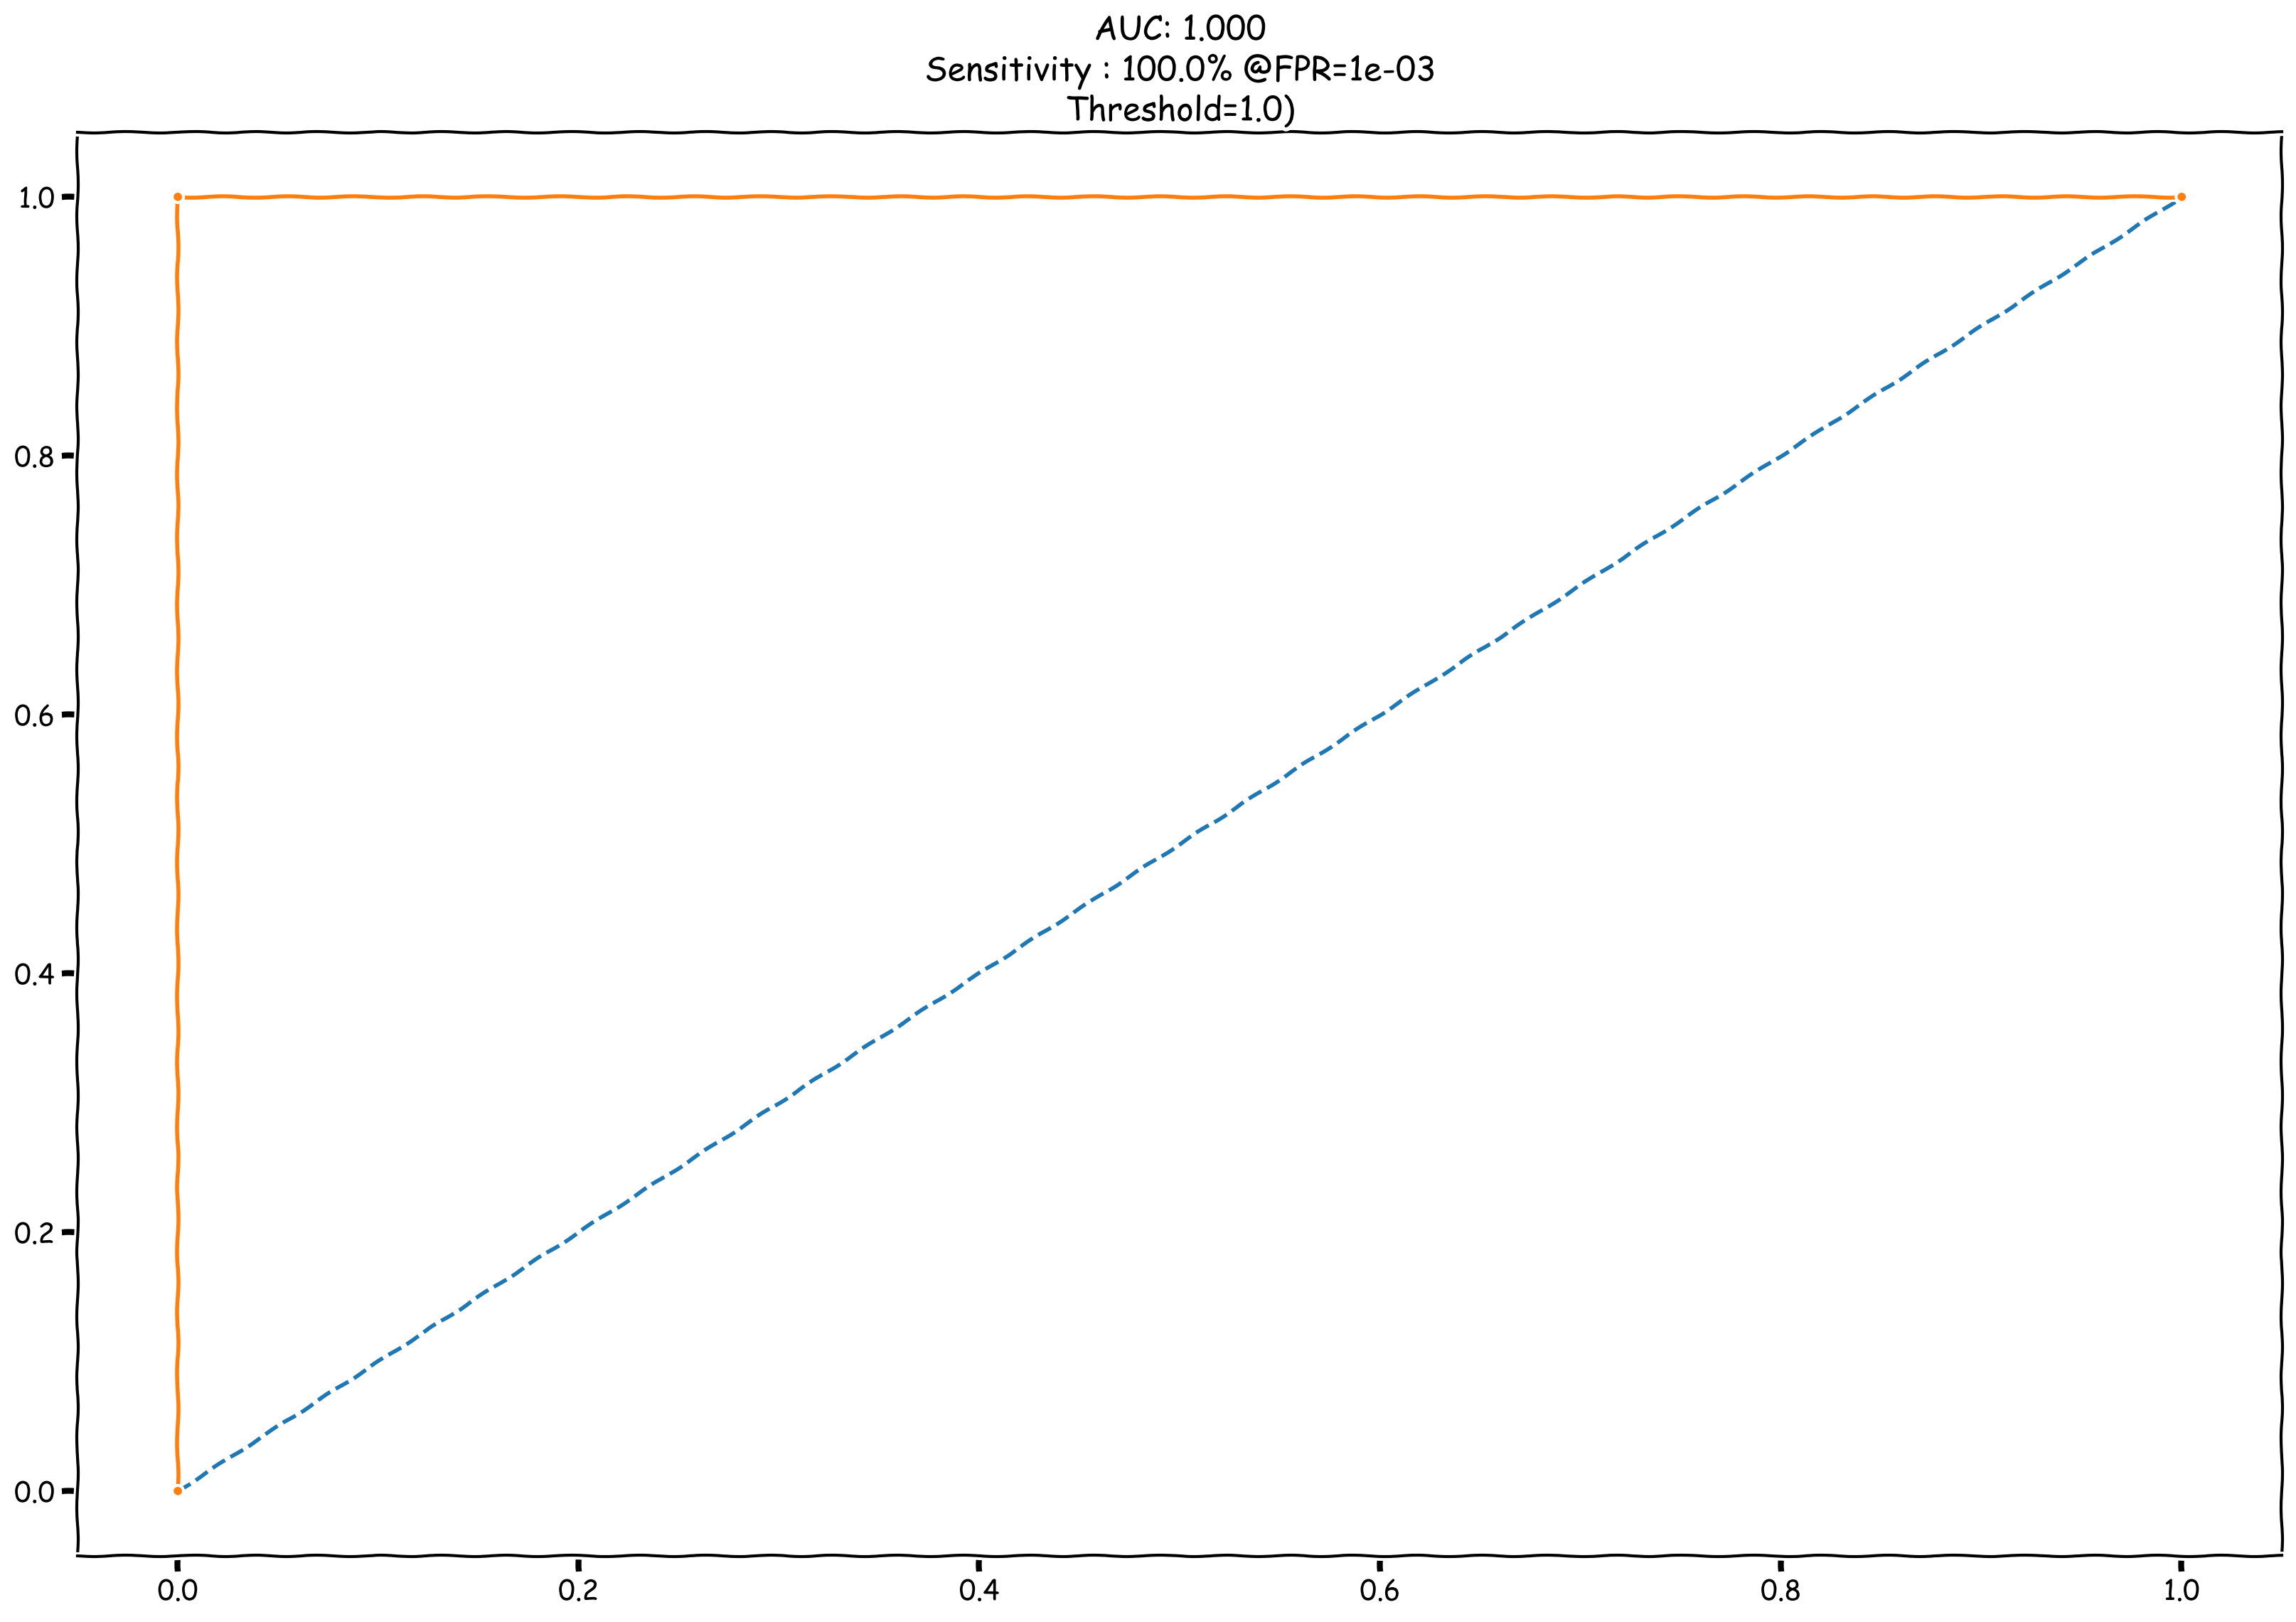

In [37]:
draw_roc(fpr, tpr, thresholds)